## Introduction to Image Processing with Python
### Image Processing (RM1-VIS)
### University of Southern Denmark

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

In [48]:
def plotImage(image, title):
    if(len(image.shape) == 2):
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

#### Frequency Domain Filtering

The following functions will be useful. I recommended to center spectra using the *shift functions instead of multiplying inputs by (-1)^x as described in the book.
```
numpy.fft.fft2
numpy.fft.ifft2
numpy.fft.fftshift
numpy.fft.ifftshift
```
Note: Numpy also provides specialized functions for real valued inputs which are slightly more efficient.

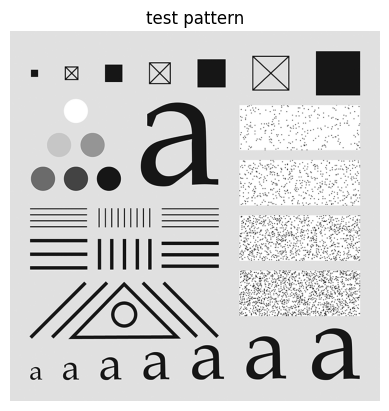

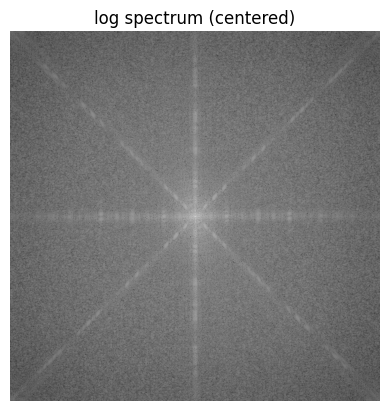

In [49]:
imgTestPattern = skimage.io.imread('images/characterTestPattern688.tif')
plotImage(imgTestPattern, "test pattern")
plotImage(np.log(np.abs(np.fft.fftshift(np.fft.fft2(imgTestPattern)))), "log spectrum (centered)")

1. Implement the general frequency domain filtering approach in the following function.

In [50]:
# helper function to apply a given filter in frequency domain
# img: input image in spatial domain
# H: filter transfer function
# return: filtered image in spatial domain
def filterFreqDom(img, H):

     # 1. Compute 2D FFT of image
    F = np.fft.fft2(img)

    # 2. Shift FFT to center
    F_shifted = np.fft.fftshift(F)

    # 3. Apply filter in frequency domain
    G = H * F_shifted

    # 4. Inverse shift
    G_ishift = np.fft.ifftshift(G)

    # 5. Compute inverse FFT to go back to spatial domain
    imgFiltered = np.fft.ifft2(G_ishift)

    # 6. Take real part (remove numerical noise)
    imgFiltered = np.real(imgFiltered)

    return imgFiltered

2. Implement the GLPF for frequency domain filtering. Hint: see equations (4-107) and (4-108).

In [51]:
def GLPF(img, sigma):
    F = np.fft.fft2(img)
    F_shifted = np.fft.fftshift(F)
    M, N = img.shape # get image dimensions
     # create meshgrid for frequency domain
    u = np.arange(0, M)
    v = np.arange(0, N)
    U, V = np.meshgrid(u, v, indexing='ij')
    D = U**2 + V**2
    H = np.exp(-D / (2 * (sigma ** 2))) #equation 4-107 but a little changed. Now it looks like H(u,v) = exp(-(u^2+v^2)/(2*sigma^2)) instead of H=A*exp((-u^2)/2*sigma^2)
    img = filterFreqDom(img, H)
    
    return img

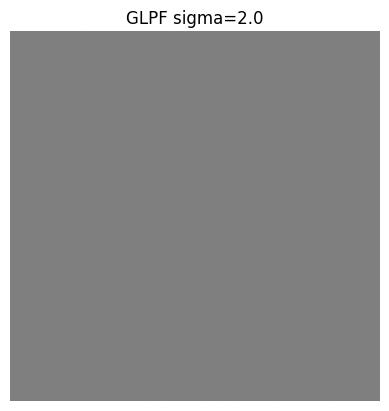

In [52]:
imgFiltered = GLPF(imgTestPattern, 2.0)
plotImage(imgFiltered, 'GLPF sigma=2.0')

2. Implement a BHPF to enhance the smudged fingerprint image. Threshold the highpass filtered image as shown in Fig. 4.55. Ref. table 4.6.

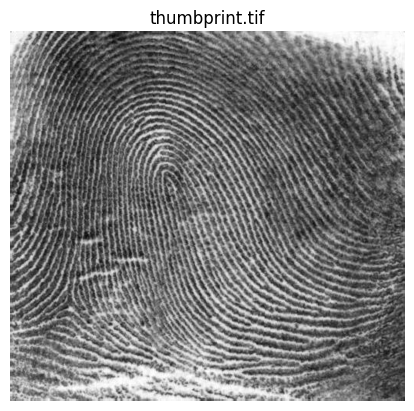

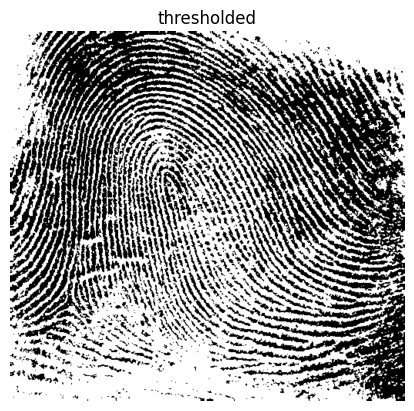

In [53]:
imgPrint = skimage.io.imread('images/thumbprint.tif')
plotImage(imgPrint, "thumbprint.tif")
plotImage(imgPrint > 128, "thresholded")

In [54]:
def BHPF(img, cutoff, order):
    M, N = img.shape
    u = np.arange(0, M)
    v = np.arange(0, N)
    U, V = np.meshgrid(u, v, indexing='ij')
    D = np.sqrt(U**2 + V**2)
    F = np.fft.fft2(img)
    F_shifted = np.fft.fftshift(F)
    H = 1/(1 + (cutoff/(D+1e-8)**(2*order)))
    Shift = H * F_shifted
    G = np.fft.ifftshift(Shift)
    img = np.real(np.fft.ifft2(G))
    return img

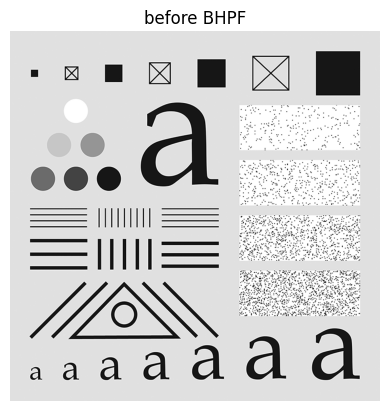

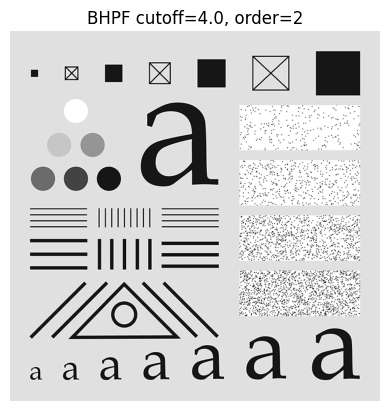

In [55]:
plotImage(imgTestPattern, 'before BHPF')
imgFiltered = BHPF(imgTestPattern, 4.0, 2)
plotImage(imgFiltered, 'BHPF cutoff=4.0, order=2')

3. Perform image registration between the two images to estimate the shift. This is known as "phase correlation", and based on the Fourier shift properties, eq (4-71) and eq (4-72).

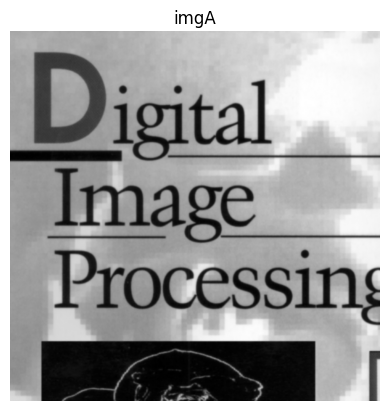

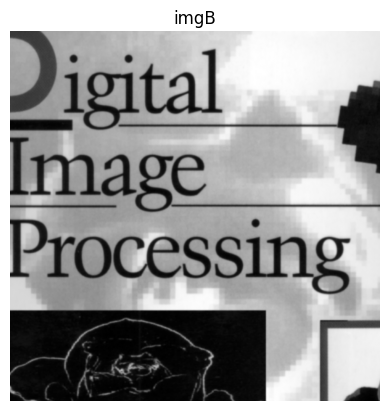

In [56]:
imgBook = skimage.io.imread('images/book-cover.tif')
shift = (50, 80)
imgA = imgBook[0: 600, 0:600]
imgB = imgBook[0+shift[0]: 600+shift[0], 0+shift[1]:600+shift[1]]
plotImage(imgA, "imgA")
plotImage(imgB, "imgB")

In [ ]:
def estim_shift(img_A, img_B):
    im1 = np.fft.fft2(img_A)
    im2 = np.fft.fft2(img_B)
    R = (im1 * np.conj(im2)) / np.abs(im1 * np.conj(im2))
    r = np.fft.ifft2(R)
    
    return img

